# Style Transfer

In [10]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
% matplotlib inline

# Seaborn config
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
sns.set(font_scale=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Images
from IPython.display import Image
from io import BytesIO
import scipy
import requests

# Keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend
from keras.preprocessing.image import load_img,img_to_array

# Loading images

In [3]:
base_path = "images/berber-sand-dune_92524_990x742.jpg"
style_path = "images/20170213_135820.jpg"

##### This is the base image

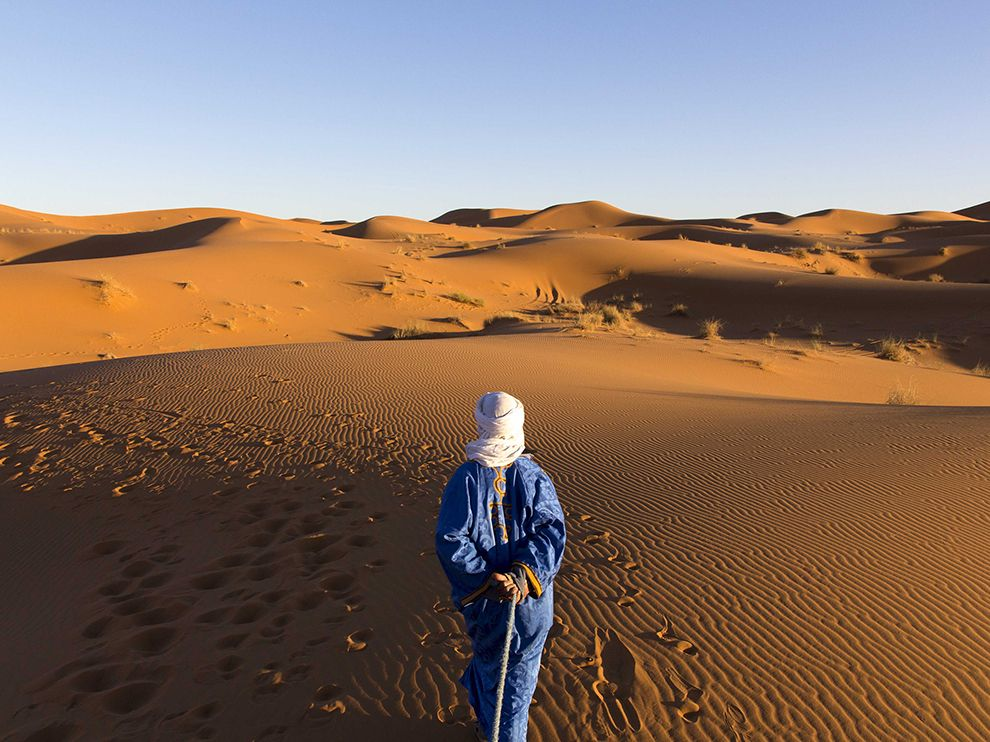

In [4]:
Image(filename = base_path)

##### Style image

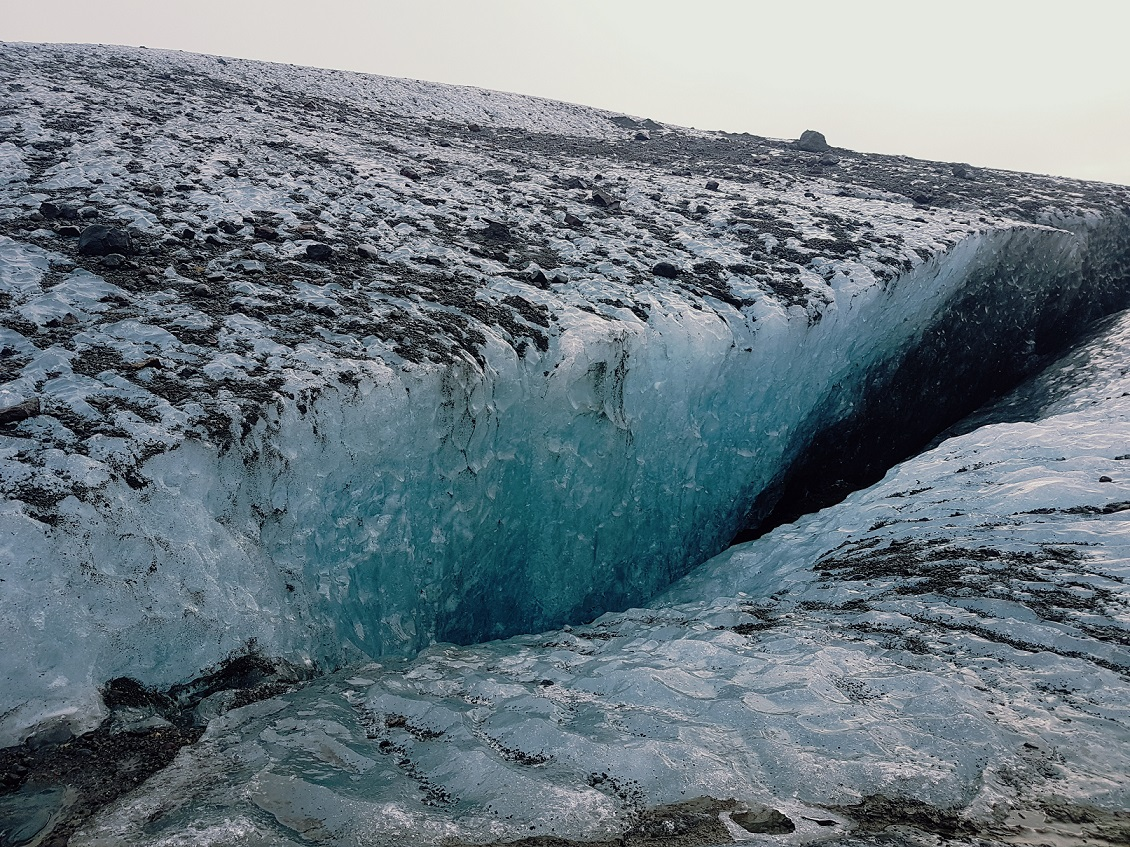

In [5]:
Image(style_path)

# Building model

## Preprocessing

The base image size is 

In [6]:
scipy.misc.imread(base_path,flatten = False).shape

(742, 990, 3)

In [7]:
def preprocess_image(filename):
    img = scipy.misc.imread(filename,flatten = False)
    img = scipy.misc.imresize(img,(724,990),'cubic')
    img = np.asarray(img,dtype = "float32")
    img = np.expand_dims(img,axis = 0)
    img = preprocess_input(img)
    return img

In [8]:
base_shape = preprocess_image(base_path).shape
base_shape

(1, 724, 990, 3)

In [9]:
preprocess_image(style_path).shape

(1, 724, 990, 3)

## Prepare the tensors and model
##### Concatenate the two images in a tensor

In [13]:
# Create the three tensors
base_image = backend.variable(preprocess_image(base_path))
style_image = backend.variable(preprocess_image(style_path))
combination_image = backend.placeholder(base_shape)

# Concatenate them
input_tensor = backend.concatenate([base_image,style_image,combination_image],axis = 0)

##### Loading the pre-trained VGG-16 model

In [14]:
model = VGG16(input_tensor = input_tensor,weights='imagenet', include_top=False)

## Define the losses

### Content loss

### Style loss

### Total loss

##### Final function

##### Using it to find the total loss

In [ ]:
loss = total_loss(model,combination_image)
print(loss)

## Optimization

### Getting the gradient of the generated image with respect to the loss

In [ ]:
gradients = backend.gradients(loss,combination_image)
print(gradients)

### Run the optimizer (L-BGFS) to minimize the loss